In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [2]:
import pathlib

# 로컬 데이터 경로 설정
data_dir = pathlib.Path("./dataset/")

# data_dir을 바로 사용하여 데이터를 불러올 수 있음

In [3]:
image_count = len(list(data_dir.glob('*/*.JPG'))+list(data_dir.glob('*/*.jpg')) )
print(image_count)

20723


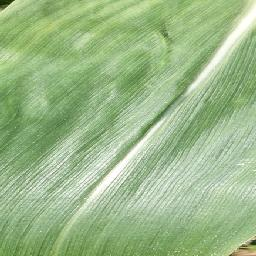

In [4]:
corn_healthy_datasets = list(data_dir.glob('Corn___healthy/*'))
PIL.Image.open(str(corn_healthy_datasets[0]))

In [5]:
# 매개변수 정의
batch_size = 32
img_height = 180
img_width = 180

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20724 files belonging to 14 classes.
Using 16580 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20724 files belonging to 14 classes.
Using 4144 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['Corn___Common_rust', 'Corn___Gray_leaf_spot', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___healthy']


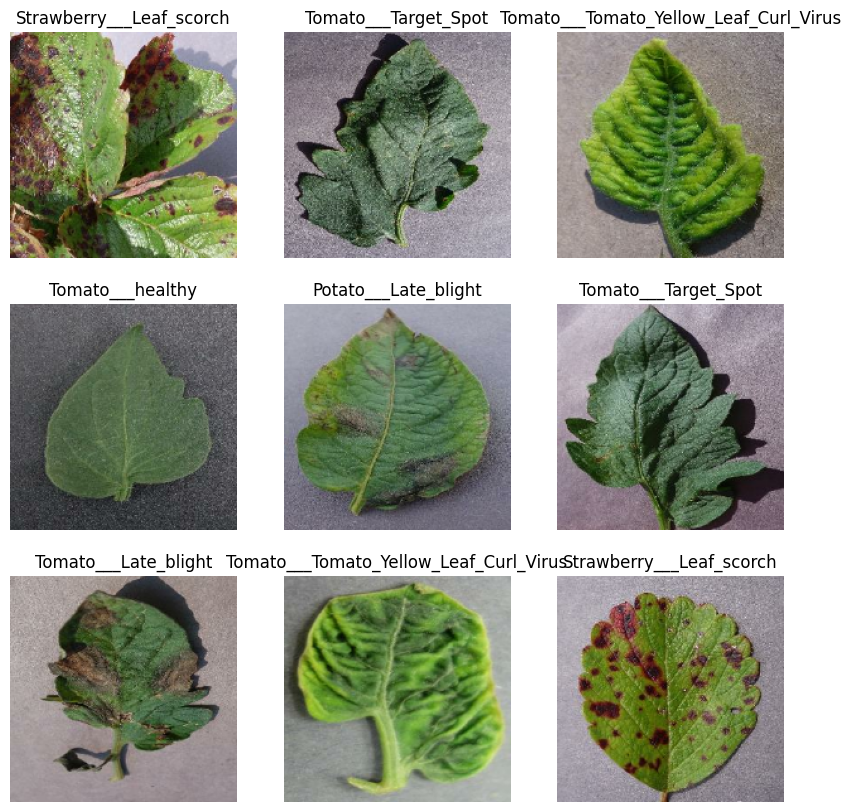

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9827166


In [13]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# 모델 훈련하기

- 데이터 증강 및 드롭아웃 실행

In [26]:
# 생모델 훈련
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
519/519 [==============================] - 85s 163ms/step - loss: 0.1124 - accuracy: 0.9603 - val_loss: 0.1839 - val_accuracy: 0.9370
Epoch 2/10
519/519 [==============================] - 86s 166ms/step - loss: 0.1019 - accuracy: 0.9646 - val_loss: 0.1375 - val_accuracy: 0.9525
Epoch 3/10
519/519 [==============================] - 86s 166ms/step - loss: 0.0950 - accuracy: 0.9630 - val_loss: 0.2175 - val_accuracy: 0.9312
Epoch 4/10
519/519 [==============================] - 81s 156ms/step - loss: 0.0991 - accuracy: 0.9636 - val_loss: 0.1371 - val_accuracy: 0.9568
Epoch 5/10
519/519 [==============================] - 81s 157ms/step - loss: 0.0973 - accuracy: 0.9651 - val_loss: 0.1473 - val_accuracy: 0.9505
Epoch 6/10
519/519 [==============================] - 79s 151ms/step - loss: 0.0829 - accuracy: 0.9713 - val_loss: 0.1830 - val_accuracy: 0.9464
Epoch 7/10
519/519 [==============================] - 81s 156ms/step - loss: 0.0864 - accuracy: 0.9692 - val_loss: 0.1603 - val_ac

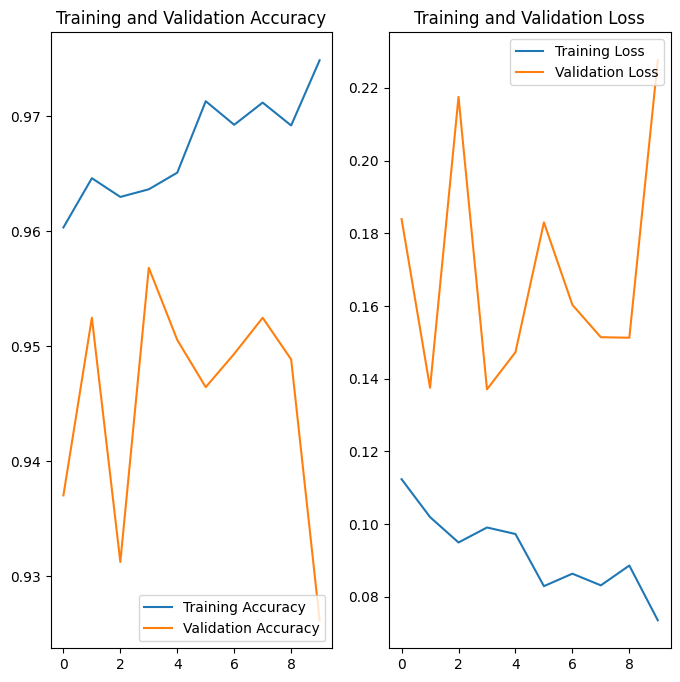

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./test-case/health-tomato.jpeg"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 모델 예측
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to Tomato___Early_blight with a 78.43 percent confidence.


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

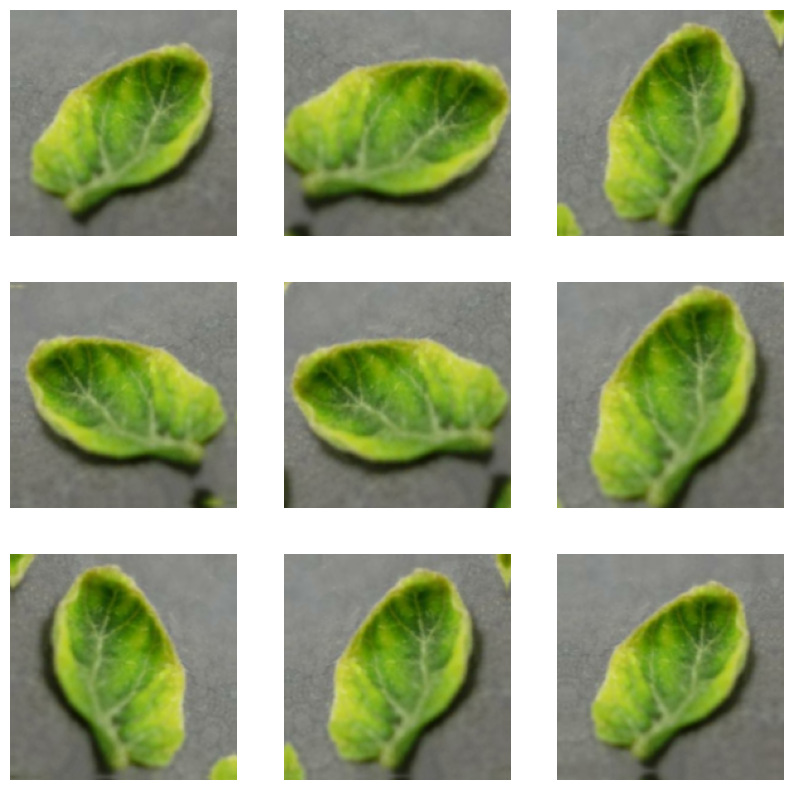

In [18]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


519/519 [==============================] - 78s 149ms/step - loss: 1.0446 - accuracy: 0.6525 - val_loss: 0.8869 - val_accuracy: 0.7261
Epoch 2/15
519/519 [==============================] - 75s 144ms/step - loss: 0.4624 - accuracy: 0.8373 - val_loss: 0.4821 - val_accuracy: 0.8333
Epoch 3/15
519/519 [==============================] - 75s 145ms/step - loss: 0.3385 - accuracy: 0.8779 - val_loss: 0.5406 - val_accuracy: 0.8241
Epoch 4/15
519/519 [==============================] - 76s 147ms/step - loss: 0.2714 - accuracy: 0.9026 - val_loss: 0.2415 - val_accuracy: 0.9153
Epoch 5/15
519/519 [==============================] - 78s 151ms/step - loss: 0.2476 - accuracy: 0.9094 - val_loss: 0.4378 - val_accuracy: 0.8468
Epoch 6/15
519/519 [==============================] - 79s 152ms/step - loss: 0.2140 - accuracy: 0.9228 - val_loss: 0.2214 - val_accuracy: 0.9172
Epoch 7/15
519/519 [==============================] - 78s 149ms/step - loss: 0.1928 - accuracy: 0.9300 - val_loss: 0.2758 - val_accuracy: 0.9

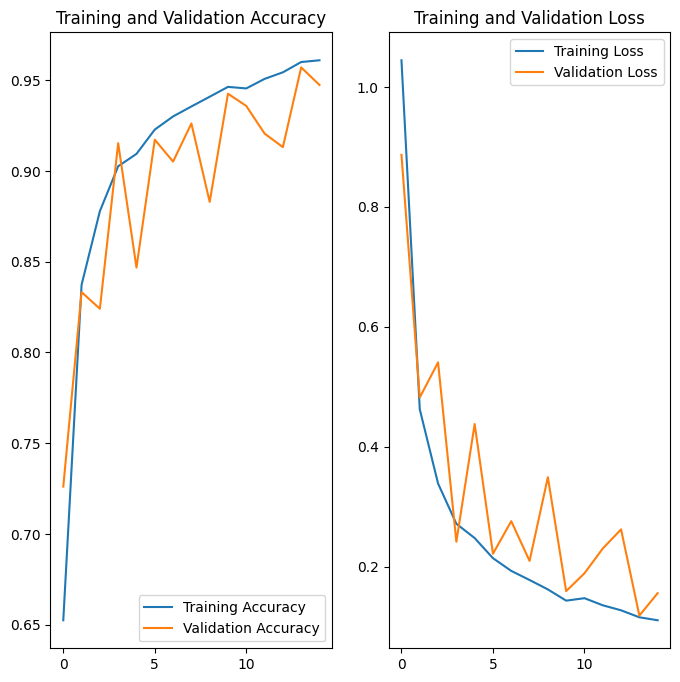

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
from keras.preprocessing import image
# 로컬 이미지 경로 설정
local_image_path = "./test-case/health_corn_test.jpeg"

# 이미지 불러오기
img = image.load_img(local_image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # 배치 차원 추가

# 모델 예측
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# 클래스 이름과 신뢰도 출력
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 61ms/step
This image most likely belongs to Tomato___Early_blight with a 51.31 percent confidence.
